# Markov Logic Network
## Method Description  
**Frequent Pattern Mining + Probabilistic Logic Reasoning for Preference Prediction**

This method integrates **frequent pattern mining** and **probabilistic logic programming** to build an interpretable, rule-based recommendation model. The key steps are as follows:

1. **User Preference Extraction**  
   User-item ratings are binarized into preference indicators based on a threshold (e.g., rating ≥ 4.0). Each movie is mapped to a set of genres, allowing user preferences over genres to be derived.

2. **Frequent Pattern Mining**  
   Using the FP-Growth algorithm, frequent co-occurrence patterns among preferred genres are extracted. These patterns reflect genre combinations that are commonly liked by users.

3. **Probabilistic Rule Generation**  
   The mined frequent patterns are converted into **probabilistic logical rules** in the ProbLog language. For example, a pattern such as {action, thriller} → western is encoded as: 
   `0.03::prefers(U, western) :- prefers(U, action), prefers(U, thriller).`
   These soft rules define the probabilistic influence of known genre preferences on inferring new ones.

4. **Personalized Logic Programs**  
For each user, a personalized ProbLog program is generated, consisting of observed preferences and applicable probabilistic rules. This forms a probabilistic knowledge base for that user.

5. **Inference and Evaluation**  
The ProbLog engine performs probabilistic inference to estimate the likelihood of unknown preferences. Predictions are evaluated using RMSE and MAE to measure how well inferred preferences match actual ratings in a test set.

---

### 🔍 Highlights

- Combines data-driven patterns (via FP-Growth) with interpretable logic rules.
- Provides **transparent and explainable reasoning paths** from known preferences to inferred ones.
- Uses **ProbLog** as a lightweight alternative to MLN to perform **probabilistic soft reasoning** over discrete preference predicates.



In [3]:
import pandas as pd
from collections import defaultdict
from PAMI.frequentPattern.basic import FPGrowth as alg
from problog.program import PrologString
from problog import get_evaluatable
from problog.logic import Term, Constant, Var
#from problog.tasks.explain import Explain
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

import sys
import os
sys.path.append(os.path.abspath('..'))
from eval_framework.reporter import MLNRecommenderReporter as RecommenderReporter
from eval_framework.data_loader import load_data, split_data

## Hyper-Parameter

In [1]:
preference_rating_threshold = 4.0 # threshold for rating to be considered preference
preference_threshold = 0.05 # threshold for preference to be considered significant
min_support = 0.01 # minimum support for frequent patterns
alpha = 0.5 # the probability of a user liking an item if the item has a genre they like

## Load Data

In [3]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
    "IMAX"
]

In [7]:
data, movies = load_data()

movies.head()

Loading data...
Loaded 100836 ratings and 9742 movies


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [ ]:
train_data, test_data = split_data(data)
test_data = test_data.iloc[:100]

\nSplitting data...
Training set size: 80668, Test set size: 20168


: 

## Feature Engineering

### Discover user preference

In [6]:
# ratings: DataFrame with userId, movieId, rating
binary_ratings = train_data[train_data["rating"] >= preference_rating_threshold]
binary_ratings

,userId,movieId,rating,timestamp
50582,326,71462,4.0,1322252335
99603,610,1127,4.0,1479544102
52544,343,2329,4.0,1202061289
64437,414,36517,4.0,1139849175
22977,156,3072,4.0,946799453
...,...,...,...,...
82386,522,86347,5.0,1388124972
6265,42,4005,4.0,996259059
54886,364,141,4.0,869443367
76820,480,6867,4.0,1179163171


In [7]:
user_preferences = pd.DataFrame(index=binary_ratings['userId'].unique(), columns=genres, dtype=float).fillna(0)
for row in binary_ratings.itertuples():
    movie_genres = movies.loc[row.movieId, 'genres']
    total_utility = len(movie_genres)
    #print(movie_genres)
    for genre in movie_genres:
        if genre not in user_preferences.columns:
            continue
        user_preferences.at[row.userId, genre] += 1/total_utility
user_preferences.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX
326,6.909524,5.566667,0.000000,0.000000,4.333333,8.942857,3.500000,35.809524,0.750000,0.250000,0.833333,0.000000,1.626190,3.400000,1.009524,12.309524,6.033333,0.333333,0.392857
610,55.909524,28.966667,8.850000,4.850000,68.100000,38.959524,3.500000,90.909524,14.533333,0.883333,39.966667,2.650000,14.209524,13.850000,29.742857,59.476190,6.783333,4.183333,5.676190
343,1.866667,2.450000,0.783333,0.450000,4.366667,4.166667,2.000000,5.750000,1.250000,0.250000,0.833333,0.000000,1.083333,1.166667,1.666667,3.250000,0.333333,0.333333,0.000000
414,61.409524,49.269048,17.052381,19.035714,172.002381,53.526190,20.833333,290.652381,25.842857,2.200000,9.033333,12.726190,16.242857,71.626190,38.852381,67.876190,22.116667,10.866667,5.835714
156,2.866667,6.066667,0.700000,2.033333,32.000000,13.950000,2.000000,57.866667,3.616667,3.583333,0.833333,2.866667,7.400000,17.483333,1.083333,10.566667,3.916667,0.833333,0.333333


### Frequent Pattern Mining

In [8]:
# Normalize user preferences
normalized_user_preferences = user_preferences.div(user_preferences.sum(axis=1), axis=0)
# Convert normalized preferences to binary based on the threshold
binary_user_preferences = normalized_user_preferences>=preference_threshold

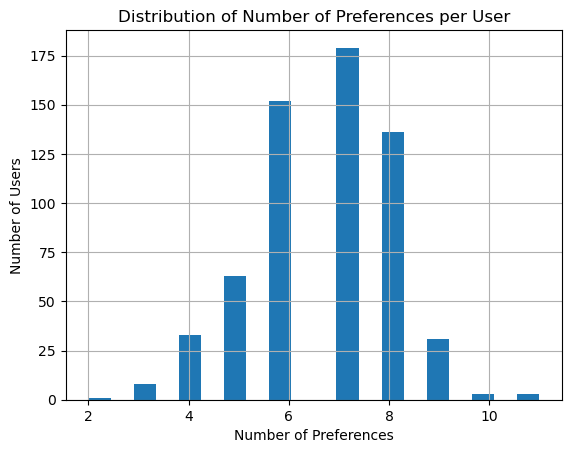

In [9]:
number_of_preferences = binary_user_preferences.sum(axis=1)
number_of_preferences.hist(bins=20)
plt.xlabel('Number of Preferences')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Preferences per User')
plt.show()

In [10]:
transactions = defaultdict(list)
for userId in binary_user_preferences.index:
    transactions[userId] = binary_user_preferences.columns[binary_user_preferences.loc[userId]].tolist()
    #user_preferences.loc[userId, user_preferences.loc[userId] == False] = 0

In [11]:
transactions_df = pd.DataFrame(columns=["Transactions"])
for userId, items in transactions.items():
    transactions_df.loc[userId, 'Transactions'] = ",".join(list(set(items)))

In [12]:
minSup=300
obj = alg.FPGrowth(iFile=transactions_df, minSup=min_support, sep=',')
#obj.mine()  #deprecated
obj.mine()
obj.save('mln/frequentPatterns.txt')
frequentPatternsDF= obj.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime
print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 1910
Runtime: 0.0348820686340332
Memory (RSS): 227250176
Memory (USS): 177082368


In [13]:
pattern_encoded = frequentPatternsDF['Patterns'].apply(lambda x: ' '.join(sorted(x.split())))
pattern_dict = {row['Patterns']: row['Support'] for index, row in frequentPatternsDF.iterrows()}

## Create MLN database

### World

In [14]:
with open('mln/world.pl', 'w') as f:
    base_prob = 0.9
    for i in range(1, 6):
        f.write(f'{base_prob/i}::likes(U, M):- prefers(U, G), has_genre(M, G), has_{i}_genre(M).\n')
    f.write(f'{base_prob/6.0}::likes(U, M):- prefers(U, G), has_genre(M, G), has_more_than_5_genre(M).\n')
    #f.write(f'{alpha}::likes(U, M) :- prefers(U, G), has_genre(M, G).\n')
    for userId, items in transactions.items():
        for item in items:
            f.write(f'prefers(user{userId}, {item.lower()}).\n')

    for movieId, row in movies.iterrows():
        if len(row['genres'])<=5:
            f.write(f'has_{len(row['genres'])}_genre(movie{movieId}).\n')
        else:
            f.write(f'has_more_than_5_genre(movie{movieId}).\n')
        for genre in row['genres']:
            if genre == '(no genres listed)':
                continue
            f.write(f'has_genre(movie{movieId}, {genre.lower()}).\n')

### Preference

In [15]:
with open('mln/preference.pl', 'w') as f:
    # rules 定義
    for row in frequentPatternsDF.itertuples(index=True):
        print(row)
        items = row.Patterns.split()
        if len(items) < 2:
            continue
        for i in range(len(items)):
            body = ' '.join(sorted(items[:i]+items[i+1:]))
            if body not in pattern_dict:
                continue
            print(body)
            total_support = pattern_dict[body]
            head = items[i]
            sub_total_support = row.Support
            f.write(f'{sub_total_support/total_support:.2f}::prefers(u, {head.lower()}) :-')
            for item in body.split():
                f.write(f'prefers(u, {item.lower()})')
                if item != body.split()[-1]:
                    f.write(', ')

            f.write(f'.\n')

Pandas(Index=0, Patterns='Western', Support=17)
Pandas(Index=1, Patterns='Western Romance', Support=8)
Romance
Western
Pandas(Index=2, Patterns='Western Romance Drama', Support=8)
Pandas(Index=3, Patterns='Western Crime', Support=9)
Crime
Western
Pandas(Index=4, Patterns='Western Crime Comedy', Support=7)
Pandas(Index=5, Patterns='Western Crime Comedy Drama', Support=7)
Pandas(Index=6, Patterns='Western Crime Comedy Action', Support=7)
Pandas(Index=7, Patterns='Drama Western Crime Comedy Action', Support=7)
Pandas(Index=8, Patterns='Western Crime Thriller', Support=8)
Crime Thriller
Pandas(Index=9, Patterns='Drama Western Crime Thriller', Support=8)
Pandas(Index=10, Patterns='Action Western Crime Thriller', Support=8)
Pandas(Index=11, Patterns='Drama Action Western Crime Thriller', Support=8)
Pandas(Index=12, Patterns='Western Crime Drama', Support=9)
Crime Drama
Pandas(Index=13, Patterns='Western Crime Action', Support=9)
Pandas(Index=14, Patterns='Drama Western Crime Action', Support

### Query (For prediction)

In [16]:
with open('mln/query.pl', 'w') as f:
    for row in test_data.iloc[:].itertuples():
        f.write(f'query(likes(user{row.userId}, movie{row.movieId})).\n')

## Predict

In [17]:
world_str = open('mln/world.pl').read() + open('mln/preference.pl').read()
queries = open('mln/query.pl').read().splitlines()

In [18]:
def parse_result(result):
    parsed = pd.DataFrame(columns=['userId', 'movieId', 'probability'])
    for key, value in result.items():
        if isinstance(key, Term):
            #print(key.args[0])
            user = str(key.args[0])
            movie = str(key.args[1])
            parsed.loc[len(parsed)] = {
                'userId': int(user[4:]),  # Extract userId from Term
                'movieId': int(movie[5:]),  # Extract movieId from Term
                'probability': value
            }
    return parsed

In [19]:
batch_size = 1000
prediction = pd.DataFrame(columns=['userId', 'movieId', 'probability'])

with tqdm(total=len(queries)) as pbar:
    pbar.set_description("Evaluating queries")
    for i in range(0, len(queries), batch_size):
        batch_queries = queries[i:i + batch_size]
        query_str = "\n".join(batch_queries)
        result = parse_result(get_evaluatable().create_from(PrologString(world_str + query_str)).evaluate())
        prediction = pd.concat([prediction, result], ignore_index=True)
        pbar.update(len(batch_queries))



Evaluating queries: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


<Axes: >

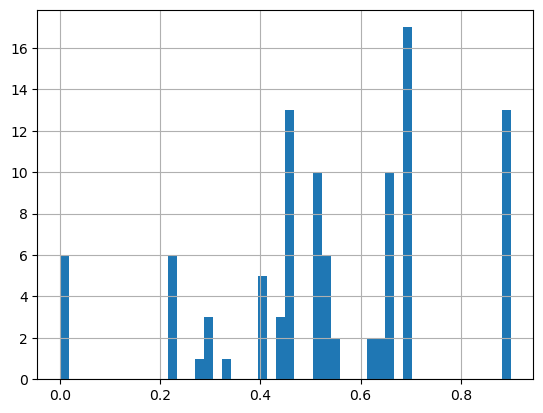

In [20]:
prediction['probability'].hist(bins=50)

Extracting user preferences...
Mining frequent patterns...
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Generating logic rules...
Calculating movie statistics...


Evaluating queries: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


### Calculate the rating distribution of each movie

For each movie $ m $, we calculate:

- Mean rating:  
  $ \mu_m = \text{mean}(\text{ratings}_m) $
- Standard deviation:  
  $ \sigma_m = \text{std}(\text{ratings}_m) $
- Rating count:  
  $ n_m = \text{count}(\text{ratings}_m) $

To handle movies with too few ratings, we replace the mean and std with the overall dataset statistics if $ n_m < 10 $:

$$
\mu_m =
\begin{cases}
\mu_{\text{overall}} & \text{if } n_m < 10 \\
\mu_m & \text{otherwise}
\end{cases}
\quad\quad
\sigma_m =
\begin{cases}
\sigma_{\text{overall}} & \text{if } n_m < 10 \\
\sigma_m & \text{otherwise}
\end{cases}
$$

These adjusted statistics will be used later to convert predicted like probabilities into estimated ratings.


In [22]:
overall_std = data['rating'].std()
overall_mean = data['rating'].mean()

movie_stats = data.groupby('movieId')['rating'].agg(['mean', 'std', 'count'])

movie_stats['mean'] = movie_stats.apply(
    lambda row: overall_mean if row['count'] < 10 else row['mean'], axis=1
)

movie_stats['std'] = movie_stats.apply(
    lambda row: overall_std if row['count'] < 10 else row['std'], axis=1
)

rating_mean = movie_stats['mean']
rating_std = movie_stats['std']

In [23]:
def infer_rating(mu, sigma, prob_likes):
    p = np.clip(prob_likes, 0.0, 1.0)
    score = np.clip(norm(mu, sigma).ppf(p), 0.5, 5.0)
    return  round(score * 2) / 2

In [24]:
prediction['rating'] = prediction.apply(
    lambda x: infer_rating(rating_mean.loc[x.movieId], rating_std.loc[x.movieId], x.probability), axis=1)

In [25]:
prediction.to_csv('mln/prediction.csv', index=False)

## Evaluation

Text(0, 0.5, 'Frequency')

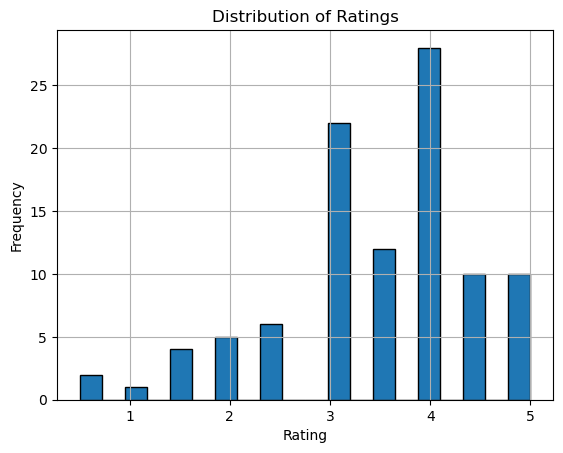

In [26]:
test_data['rating'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Distribution of Predicted Ratings')

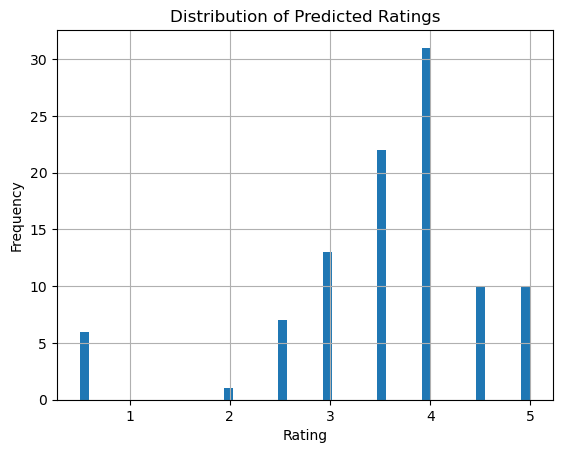

In [27]:
prediction['rating'].hist(bins=50)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Ratings')

In [32]:
y_pred = test_data.merge(model_predictions, on=['userId', 'movieId'], how='left')['rating_y']
y_true = test_data['rating']

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 1.2217
MAE: 0.8950


Text(0, 0.5, 'Predicted Ratings')

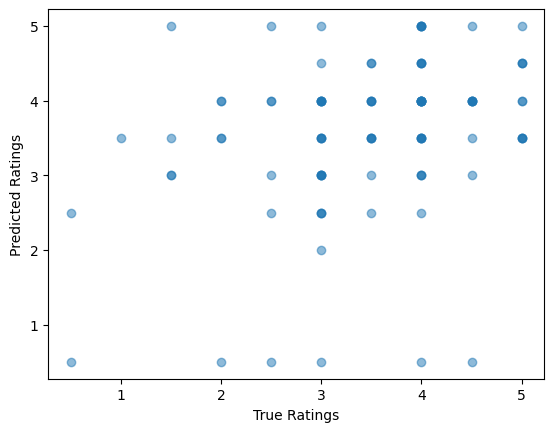

In [29]:
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')

In [30]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
rmse = root_mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f'RMSE: {rmse:.4f} | MAE: {mae:.4f}')

RMSE: 1.1990 | MAE: 0.8850
